In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')                
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')                
      
    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)   
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out

class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), input_shape=[None, None, 3], data_format='channels_last',
                                            padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')                
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')              
        self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv9 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')      

        self.conv11 = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv13 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv14 = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)                        

        self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

        self.aspp = ASPPBlock()

    def call(self, x):
      #  out = tf.keras.layers.Input((420, 420, 3))(x)
        out = self.conv1(x) # x
        out = self.conv2(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool(out)        
        out = self.conv5(out)
        out = self.conv6(out)
        out_enc_mid = out
        out = self.maxpool(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.maxpool(out)      
        out = self.conv9(out)
        out = self.conv10(out)

        out = self.aspp(out)      

        out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)
        # в два раза изображение увеличиваем

        out_enc_mid = self.conv11(out_enc_mid)

        out = tf.concat([out, out_enc_mid], axis=3)

        out = self.conv12(out)
        out = self.conv13(out)
        out = self.conv14(out)

        out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out

model = ASPPNet()

In [0]:
import os
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
os.chdir('drive/My Drive/')

In [0]:
if 0:
    #!mkdir -p data
    
    #!cd data && wget http://images.cocodataset.org/zips/train2017.zip
    #!cd data && wget http://images.cocodataset.org/zips/val2017.zip
    #!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

    #!cd data && unzip -q train2017.zip
    #!cd data && unzip -q val2017.zip
    #!cd data && unzip -q annotations_trainval2017.zip     

    #!cd data && git clone https://github.com/cocodataset/cocoapi
    #!cd data/cocoapi/PythonAPI && make
    pass

In [0]:
# Подготовка COCO API

COCO_ROOT = 'drive/My Drive/data'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

In [0]:
# Универсальный класс Dataset для сегментации
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size=None, epochs=None, inp_size=None):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[..., :3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[..., 3:4], tf.float32)
            return img, mask_class
        
        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        #dataset = dataset.repeat(epochs)
        #dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size=None, inp_size=None):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[..., :3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[..., 3:4], tf.float32)
            return img, mask_class
       
        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        #dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset


In [0]:
# Класс для сегментационного датасета COCO

class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join('/content/', COCO_ROOT, 'annotations/instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        '''img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        with ZipFile('data/{}2017.zip'.format(sublist), 'r') as zip:
          zip.extract(img_fname, '/content/drive/My Drive/data')

        img = io.imread(os.path.join(COCO_ROOT, img_fname))'''
        img = io.imread(img_data['coco_url'])
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))
        

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined
      

In [9]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=14.89s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [0]:
INP_SIZE = 420

In [0]:
train_ds = COCO_dataset_train.train_dataset(inp_size=INP_SIZE)
val_ds = COCO_dataset_val.val_dataset(inp_size=INP_SIZE)

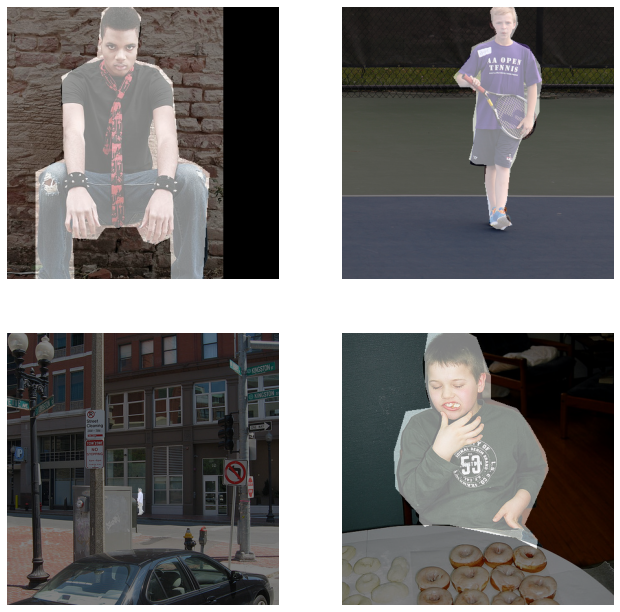

In [12]:
some_samples = [x for x in iter(train_ds.take(4))]

fig = plt.figure(figsize=(11, 11))
for j in range(len(some_samples)):
    ax = fig.add_subplot(2, 2, j+1)
    sample = some_samples[j]
    ax.imshow(sample[0].numpy()*0.5+sample[1].numpy()*0.5)
    plt.axis('off')

In [0]:
def another_mask(img, mask):
    mask = tf.math.reduce_mean(mask, axis=2)
    return img, tf.cast(mask, tf.uint8)

In [0]:
NUM_EPOCHS = 1
BATCH_SIZE = 10

train_ds = train_ds.map(another_mask)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

val_ds = val_ds.map(another_mask)
val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=True)

In [19]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

hist = model.fit(train_ds, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

ValueError: ignored